In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive as NEA

In [19]:
# Absolute Magnitude Function
def calc_abs_mag(Vmag, distance):
    '''Calculates the absolute magnitude.

        Parameters
        ----------
        Vmag: The apparent magnitude of the star as seen from Earth.
        distance: The distance of the star from Earth in parsecs.

        Returns
        -------
        float: The absolute magnitude of the star.'''
    
    return Vmag - 5 * np.log10(distance/10)

In [63]:
# Load in the stellar data from the Nasa Exoplanet Archive
data = NEA.query_criteria(
    table='stellarhosts',
    select='st_teff, st_lum, st_spectype, sy_vmag, sy_dist'
)

In [103]:
# Mask any NaN values in each column used
stars = data.to_pandas()
mask = stars["st_teff"].notna() & stars["st_spectype"] & stars["sy_vmag"].notna() & stars["sy_dist"].notna()

teffs = stars["st_teff"][mask]
spectypes = stars["st_spectype"][mask]
vmags = stars["sy_vmag"][mask]
distances = stars["sy_dist"][mask]

# Generate absolute magnitude
abs_mags = calc_abs_mag(vmags, distances)

# Calculate stellar luminosity as a ratio of the Sun's luminosity
lums = 100.4 * (4.85 - abs_mags)

# Calculate the B-V color index
b_v = -0.865 + 8540/teffs

(18.0, -18.0)

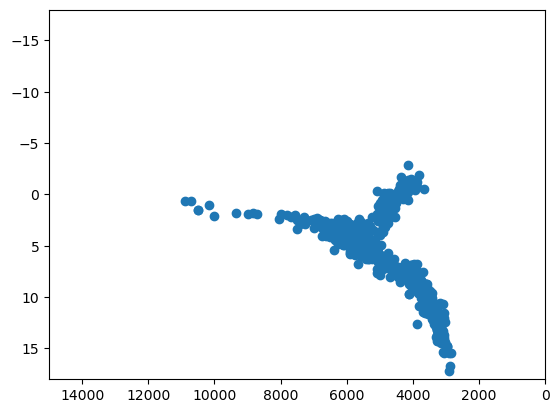

In [107]:
plt.scatter(teffs, abs_mags)
plt.xlim(15000, 0)
plt.ylim(18, -18)